In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import os
from tqdm import tqdm
import itertools
import warnings
warnings.filterwarnings('ignore')

## Test Audio

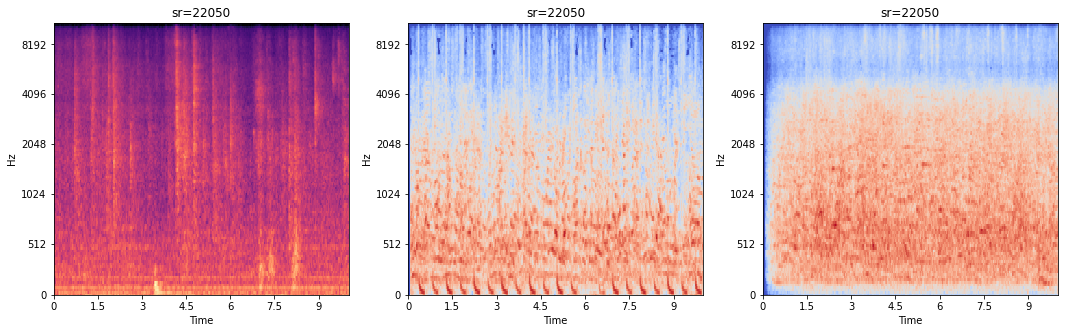

In [ ]:
mainpath = '/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/train/'

path = ['classroom/classroom-001.mp3', 'cabaret/cabaret01-001.mp3', 'large_public_room/large_public_room-001.mp3']

plt.figure(figsize=(18, 5))
for i in range(3):
    f, sr = librosa.load(mainpath+path[i])   
    S = librosa.feature.melspectrogram(f, sr)
    plt.subplot(1, 3, i+1)
    librosa.display.specshow(librosa.power_to_db(S), y_axis='mel', x_axis='time', sr=sr)
    plt.title(f'sr={sr}')

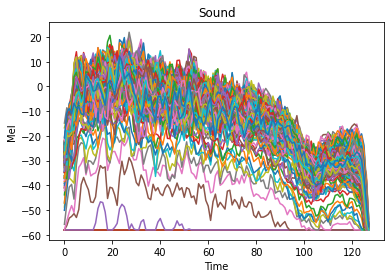

In [ ]:
plt.plot(log_mel_spectrogram3);

plt.title('Sound');

plt.xlabel('Time');

plt.ylabel('Mel');

## Data Prepessing

In [ ]:
# OLD
# def spect(wave):
#     f, sr = librosa.load("/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/"+ wave, duration = 9)
#     st = librosa.stft(f)
#     spectogram = np.abs(st)
    
#     return spectogram

In [16]:
def spect(wave):
    f, sr = librosa.load("/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/"+ wave, duration=9)
    mel_spectrogram = librosa.feature.melspectrogram(f, sr)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram

In [17]:
x = list()
y = list()
Ca_files = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/train/cabaret/')
Classr_files = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/train/classroom/')
Public_file = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/train/large_public_room/')
Constr_file = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/train/construction_site/')

for l in tqdm(Classr_files):
  file1 = "train/classroom/"+ l
  data = spect(file1) #อ่านข้อมูลเสียงทีละไฟล์
  if data.shape[1] == 388:
    x.append(data)  # อัดเข้าตัวแปร x    
    y.append([1,0,0,0]) #กำหนด label 1,0 คือ Classroom เข้าตัวแปร y

for l in tqdm(Ca_files):
  file1 = "train/cabaret/"+ l
  data = spect(file1) 
  if data.shape[1] == 388:
    x.append(data)
    y.append([0,1,0,0]) 

for l in tqdm(Public_file):
  file1 = "train/large_public_room/"+ l
  data = spect(file1)
  if data.shape[1] == 388:
    x.append(data)      
    y.append([0,0,1,0])

for l in tqdm(Constr_file):
  file1 = "train/construction_site/"+ l
  data = spect(file1)
  if data.shape[1] == 388:
    x.append(data)      
    y.append([0,0,0,1])  

100%|██████████| 350/350 [01:57<00:00,  2.99it/s]


In [18]:
X = np.array(x)
y = np.array(y)
X.shape, y.shape

((1048, 128, 388), (1048, 4))

In [19]:
from sklearn.model_selection import train_test_split
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
xtrain, xtest, ytrain, ytest = train_test_split(X,y, train_size = 0.80, random_state=223)

In [20]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((838, 128, 388, 1), (210, 128, 388, 1), (838, 4), (210, 4))

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout

In [ ]:
xtrain.shape

(965, 128, 388, 1)

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=xtrain.shape[1:]),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),

  keras.layers.Conv2D(128,(3,3) , activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),

  keras.layers.Dense(64),
  keras.layers.Dense(16),
  keras.layers.Flatten(),
 
  keras.layers.Dense(4),
  keras.layers.Activation('softmax')
])
  
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics= ['accuracy'])
batch_size = 16
epochs = 50

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 386, 128)     1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 193, 128)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 191, 128)      147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 95, 128)      0         
 2D)                                                             
                                                                 
 dense_3 (Dense)             (None, 30, 95, 64)        8256      
                                                                 
 dense_4 (Dense)             (None, 30, 95, 16)       

In [ ]:
history = model.fit(xtrain, ytrain, batch_size = batch_size ,epochs=epochs, validation_data=(xtest, ytest))

los: 0.0
val_loss: 0.0


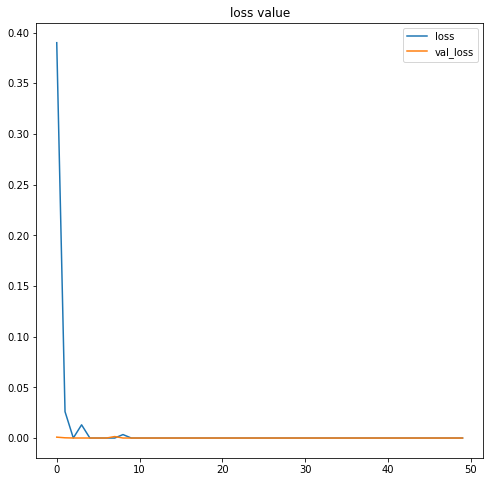

acc: 1.0
val_acc: 1.0


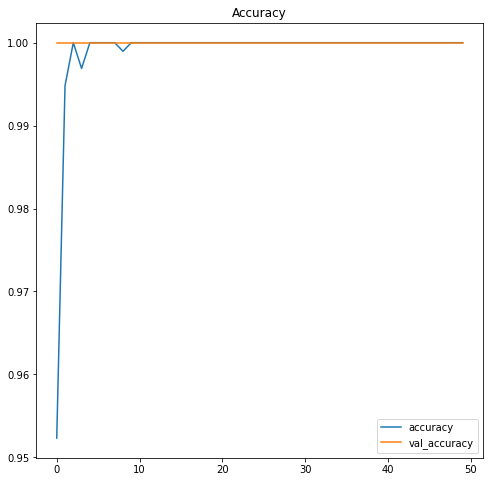

In [ ]:
plt.figure(figsize=(8,8))
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('los:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
print('acc:', history.history['accuracy'][-1])
print('val_acc:', history.history['val_accuracy'][-1])
plt.show()

In [ ]:
def wav2predict(sf): 
  data = spect(sf)
  data2arr = np.array(data) 
  testsound = data2arr.reshape(1, data2arr.shape[0], data2arr.shape[1], 1) 
  p = model.predict(testsound) 
  label = ['Classroom','Cabaret','Public','Consturction_site'] 
  i = np.argmax(p) 
  prop = np.max(p) 
  result = label[i] 
  return result , prop 

In [ ]:
def wav22predict(sf): 
  data = spect(sf)
  data2arr = np.array(data) 
  testsound = data2arr.reshape(1, data2arr.shape[0], data2arr.shape[1], 1) 
  p = model.predict(testsound) 
  i = np.argmax(p) 
  return i

In [ ]:
y_pred = []
y_testt = []

test_cab = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/test/cabaret/')
test_cls = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/test/classroom/')
test_lar = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/test/large_public/')
test_constr = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/test/construction_site/')

for l in tqdm(test_cls):
  sound = "test/classroom/"+ l
  data = spect(file1)
  r = wav22predict(sound)
  y_pred.append(r)
  y_testt.append(0)

for l in tqdm(test_cab):
  sound = "test/cabaret/"+ l
  data = spect(file1) 
  r = wav22predict(sound)
  y_pred.append(r) 
  y_testt.append(1)

for l in tqdm(test_lar):
  sound = "test/large_public/"+ l
  data = spect(file1)
  r = wav22predict(sound)
  y_pred.append(r)
  y_testt.append(2)

for l in tqdm(test_constr):
  file1 = "test/construction_site/"+ l
  data = spect(file1)
  r = wav22predict(sound)
  y_pred.append(r)
  y_testt.append(3)

# for t in tqdm(test_file):
#   sound = "test/" + t
#   # print(sound)
#   r = wav22predict(sound)
#   y_pred.append(r)

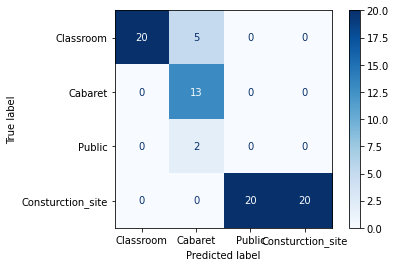

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.array(y_pred)
y_test = np.array(y_testt)
labels = ['Classroom','Cabaret','Public','Consturction_site']

cm = confusion_matrix(y_pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Prediction

In [ ]:
sound = 'train/large_public_room/large_public_room-007.mp3'
r = wav2predict(sound)
print(r)
Audio('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/'+ sound)

1/1 [==============================] - 0s 24ms/step
('Public', 1.0)


In [ ]:
test_file = os.listdir('/content/drive/MyDrive/Situation_Classification_From_Sounds/dataset/test')
y_pred = []
for t in tqdm(test_file):
  sound = "test/" + t
  r = wav22predict(sound)
  print(r)